# Online News Popularity - Feature Engineering and Modeling

## Import Libraries

In [107]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [290]:
pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 682.7 kB/s eta 0:00:03
   ---------- ----------------------------- 0.4/1.4 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 18.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [296]:
pip install catboost

   ---------------------------------------- 0.0/101.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.8 MB 682.7 kB/s eta 0:02:30
   ---------------------------------------- 0.1/101.8 MB 991.0 kB/s eta 0:01:43
    --------------------------------------- 2.4/101.8 MB 22.2 MB/s eta 0:00:05
   -- ------------------------------------- 5.5/101.8 MB 35.2 MB/s eta 0:00:03
   --- ------------------------------------ 9.6/101.8 MB 47.4 MB/s eta 0:00:02
   ---- ----------------------------------- 12.1/101.8 MB 81.8 MB/s eta 0:00:02
   ------ --------------------------------- 16.9/101.8 MB 81.8 MB/s eta 0:00:02
   -------- ------------------------------- 20.8/101.8 MB 81.8 MB/s eta 0:00:01
   --------- ------------------------------ 24.5/101.8 MB 81.8 MB/s eta 0:00:01
   ----------- ---------------------------- 28.5/101.8 MB 81.8 MB/s eta 0:00:01
   ------------ --------------------------- 31.7/101.8 MB 81.8 MB/s eta 0:00:01
   -------------- ------------------------- 36.1/101

In [328]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from textblob import TextBlob
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor



# Initialize Decision Tree Regressor
%matplotlib inline


## Load the Cleaned Dataset

In [378]:
# Load the cleaned dataset
file_path = 'data/df_clean.csv'  # Adjust the path if necessary
df_clean = pd.read_csv(file_path, index_col=0)

for col in df_clean.columns:
    df_clean.rename(columns={col:col.replace(" ", "")},inplace=True)
    
# Display the first few rows
df_clean.head()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


## Dealing with Outliers

In [380]:
#Function to create a list of variables with outliers

def outliersinColumns(df):

    '''
    function: outliersinColumns verifies if there is a True value into de dataset to indicate there is an
              outlier in a specific column
    arguments: A dataframe with boolean values
    return: A list of columns with outliers
    '''
    
    columns_outliers = []
    for column in df.columns:

        if df_clean[column].nunique() > 2:  #Apply for variables with 3 or more unique values

            for value in df[column]:
                if value:
                    columns_outliers.append(column)
                    break

    return columns_outliers

In [382]:
#Using a statistical method to detect outliers: interquartile range (IQR)

Q1 = df_clean.quantile(0.25)
Q3 = df_clean.quantile(0.75)
IQR = Q3 - Q1


#Creating notinvalidarea dataframe with boolean values:
#False means these values are into the valid area 
#True indicates presence of an outlier

notinvalidarea = (df_clean < (Q1 - 1.5 * IQR)) | (df_clean > (Q3 + 1.5 * IQR))


#Calling function outliersinColumns
columns_w_outliers = outliersinColumns(notinvalidarea)


#Printing Results
print('Columns with outliers: {}'.format(len(columns_w_outliers)))
print('\n')
print(columns_w_outliers)

Columns with outliers: 39


['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares', 'self_reference_avg_sharess', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'global_subjectivity', 'global_sentiment_polarity', 'global_rate_positive_words', 'global_rate_negative_words', 'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity', 'avg_negative_polarity', 'max_negative_polarity', 'title_sentiment_polarity', 'abs_title_sentiment_polarity', 'shares']


In [384]:

#Creating a dictionary with variables and its technique to be applied
#
#    1 - log transformation,
#    2 - one-way winsorization to the highest end,
#    3 - one-way winsorization to the lowest end,
#    4 - two-way winsorization

transformation = {'n_tokens_title':4, 'n_tokens_content':2, 'n_unique_tokens':4, 'n_non_stop_words':4, 'n_non_stop_unique_tokens':4, 
 'num_hrefs':2, 'num_self_hrefs':2, 'num_videos':2, 'average_token_length':4, 
 'num_keywords':3, 'kw_max_min':2, 'kw_avg_min':2, 
 'kw_avg_max':2, 'kw_max_avg':2, 'kw_avg_avg':4, 'global_subjectivity':4, 
 'global_sentiment_polarity':4, 'global_rate_positive_words':2, 'global_rate_negative_words':2, 
 'rate_positive_words':3, 'rate_negative_words':2, 'avg_positive_polarity':4, 'min_positive_polarity':2, 
 'avg_negative_polarity':3, 'max_negative_polarity':3, 'abs_title_sentiment_polarity':2}

In [386]:
from scipy.stats.mstats import winsorize

#Dropping outliers from dataset, this technique is applied because the outier is just one row
#onlinenews = onlinenews.drop(index=onlinenews[onlinenews['n_unique_tokens']>200].index[0])

#Transforming outliers
#    1 - log transformation,
#    2 - one-way winsorization to the highest end,
#    3 - one-way winsorization to the lowest end,
#    4 - two-way winsorization

for k in transformation:
    if transformation[k] == 1:
        df_clean[k] = np.log(df_clean[k])
        
    elif transformation[k] == 2:
        df_clean[k] = winsorize(df_clean[k],(0,0.10))

    elif transformation[k] == 3:
        df_clean[k] = winsorize(df_clean[k],(0.10,0))
        
    elif transformation[k] == 4:
        df_clean[k] = winsorize(df_clean[k],(0.10,0.10))

### Recheck Correlation

Text(0.5, 1.0, 'Correlation Matrix (Online News)')

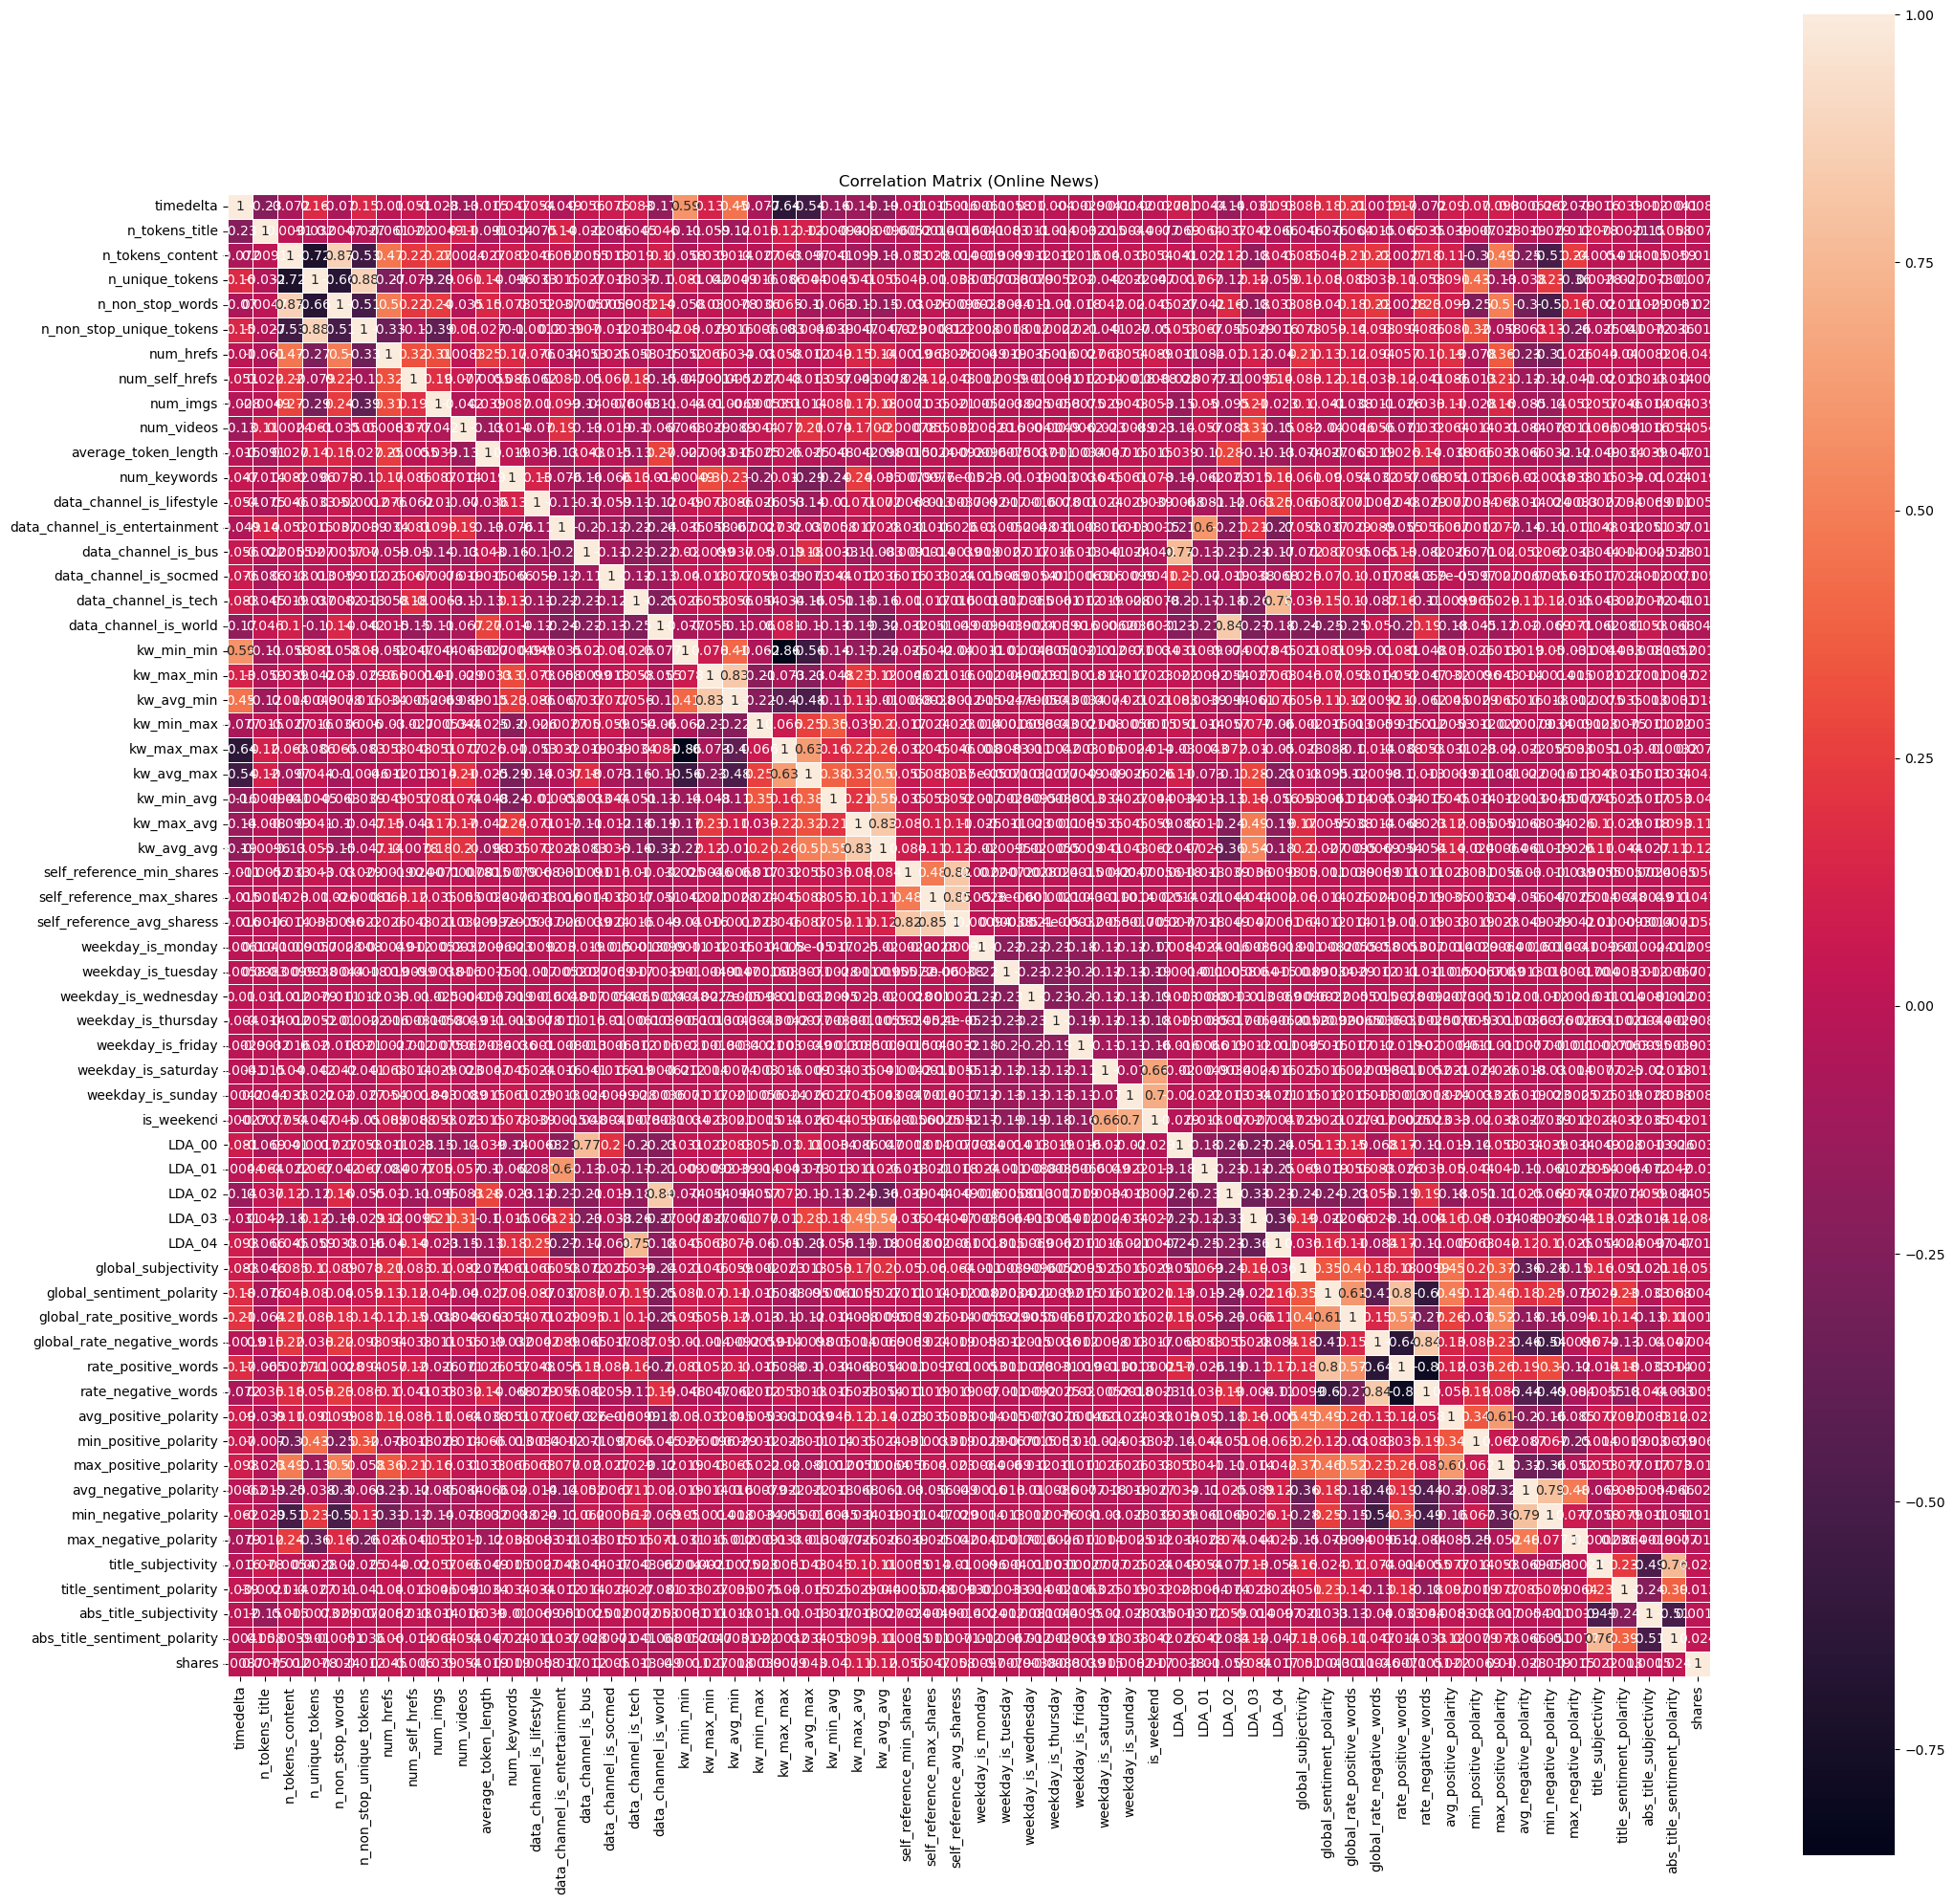

In [388]:
#Check correlation

correlation = df_clean.corr()

plt.figure(figsize=(25,25))
sns.heatmap(correlation, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix (Online News)")

In [390]:
correlation.head(5)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
timedelta,1.000000,-0.233211,-0.071554,0.164191,-0.070445,0.147116,0.010343,0.051220,-0.027636,-0.126569,...,0.069531,0.098288,0.000625,0.062175,-0.079139,-0.015919,0.038711,0.011551,-0.004082,0.008662
n_tokens_title,-0.233211,1.000000,0.009117,-0.032076,0.004716,-0.027421,-0.060520,0.022053,-0.004944,0.109599,...,-0.007003,-0.023333,-0.018862,-0.028688,0.012432,0.077621,-0.002063,-0.147129,0.058465,0.007501
n_tokens_content,-0.071554,0.009117,1.000000,-0.718489,0.870803,-0.532404,0.468414,0.224323,0.273554,0.002444,...,-0.297832,0.486256,-0.246734,-0.508320,0.244957,-0.005403,0.014230,0.014622,0.005934,-0.012172
n_unique_tokens,0.164191,-0.032076,-0.718489,1.000000,-0.655684,0.879803,-0.268414,-0.079379,-0.287299,0.060732,...,0.430082,-0.126576,-0.037770,0.228044,-0.355336,0.002823,-0.027459,-0.007273,-0.010089,0.007808
n_non_stop_words,-0.070445,0.004716,0.870803,-0.655684,1.000000,-0.506361,0.498033,0.224740,0.241489,-0.035309,...,-0.251031,0.500475,-0.299792,-0.501740,0.158858,-0.019992,0.011297,0.028537,-0.005069,-0.023658


In [392]:
#Check the correlation with target variable
correlation['shares'].sort_values(ascending=True)

LDA_02                          -0.059163
data_channel_is_world           -0.049497
avg_negative_polarity           -0.027922
n_non_stop_words                -0.023658
average_token_length            -0.019301
min_negative_polarity           -0.019297
data_channel_is_entertainment   -0.017006
LDA_04                          -0.016622
max_negative_polarity           -0.015133
data_channel_is_tech            -0.013253
data_channel_is_bus             -0.012376
n_tokens_content                -0.012172
n_non_stop_unique_tokens        -0.012068
LDA_01                          -0.010183
weekday_is_thursday             -0.008833
weekday_is_tuesday              -0.007941
rate_positive_words             -0.007097
min_positive_polarity           -0.006938
num_self_hrefs                  -0.005956
rate_negative_words             -0.005091
weekday_is_friday               -0.003884
weekday_is_wednesday            -0.003801
LDA_00                          -0.003793
kw_min_min                      -0

## Feature Engineering

In [394]:
# Step 1: Feature Extraction from Existing Columns

## Create new features from existing columns

# 1.1 Interaction Terms
# Example: Interaction between number of tokens in the title and content
df_clean['title_content_interaction'] = df_clean['n_tokens_title'] * df_clean['n_tokens_content']

# Extract readability index (e.g., Flesch Reading Ease score)
df_clean['readability_score'] = df_clean['n_tokens_content'] / (df_clean['n_unique_tokens'] + 1)  # Simplified readability score

# 1.2 Temporal Features
# Create day of the week from the publication date
df_clean['day_of_week'] = pd.to_datetime(df_clean['timedelta']).dt.dayofweek

# 1.3 Log Transformation for Highly Skewed Features
# Apply log transformation to the target variable 'shares' to reduce skewness
df_clean['log_shares'] = np.log1p(df_clean['shares'])

In [396]:
# Remove irrelevant column
df = df_clean.drop(columns=['timedelta'])  # Dropping non-relevant columns

In [398]:
# Step 2: Feature Scaling and Normalization

# Identify numerical features to scale
numerical_features = ['n_tokens_title', 'n_tokens_content', 'num_imgs', 'num_videos', 'readability_score', 'title_content_interaction']

# Apply Standard Scaling
scaler = StandardScaler()
# Scale the features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [400]:
# Step 3: Polynomial Features
# Create polynomial features for selected columns to capture non-linear relationships
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(df[['n_tokens_title', 'n_tokens_content']])

# Convert to DataFrame and merge with original data
poly_features_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['n_tokens_title', 'n_tokens_content']))
df = pd.concat([df, poly_features_df], axis=1)

In [402]:
# Step 4: Final Data Preparation

# Define features (X) and target (y)
X = df.drop(columns=['log_shares'])
y = df['log_shares']

# Final dataset preview
print(X.head())
print(y.head())

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0        0.941581         -0.873938         0.663594               1.0   
1       -0.818871         -0.760226         0.604743               1.0   
2       -0.818871         -0.899208         0.575130               1.0   
3       -0.818871          0.111568         0.503788               1.0   
4        1.528398          1.820411         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  num_videos  \
0                  0.815385        4.0             2.0 -0.426526   -0.698352   
1                  0.791946        3.0             1.0 -0.426526   -0.698352   
2                  0.663866        3.0             1.0 -0.426526   -0.698352   
3                  0.665635        9.0             0.0 -0.426526   -0.698352   
4                  0.553377       19.0             6.0  1.860061   -0.698352   

   average_token_length  ...  abs_title_sentiment_polarity  shares  \
0   

Statistic details of target (shares)
count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64




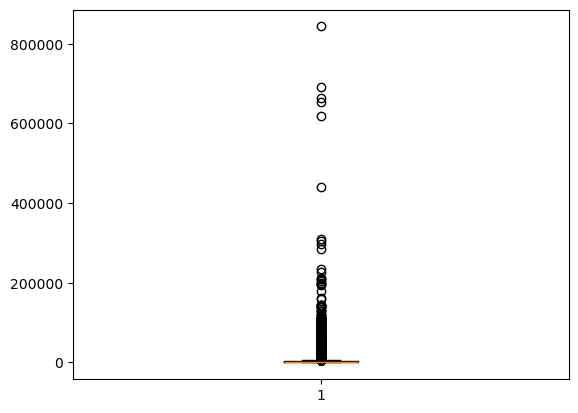

In [404]:
print('Statistic details of target (shares)')
print(df['shares'].describe())
print('\n')

plt.boxplot(df['shares'])
plt.show()

In [406]:
X.head()

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,abs_title_sentiment_polarity,shares,title_content_interaction,readability_score,day_of_week,n_tokens_title,n_tokens_content,n_tokens_title^2,n_tokens_title n_tokens_content,n_tokens_content^2
0,0.941581,-0.873938,0.663594,1.0,0.815385,4.0,2.0,-0.426526,-0.698352,4.680365,...,0.187500,593,-0.730890,-0.884764,3,0.941581,-0.873938,0.886574,-0.822883,0.763768
1,-0.818871,-0.760226,0.604743,1.0,0.791946,3.0,1.0,-0.426526,-0.698352,4.913725,...,0.000000,711,-0.827101,-0.763850,3,-0.818871,-0.760226,0.670549,0.622527,0.577943
2,-0.818871,-0.899208,0.575130,1.0,0.663866,3.0,1.0,-0.426526,-0.698352,4.393365,...,0.000000,1500,-0.941514,-0.874498,3,-0.818871,-0.899208,0.670549,0.736335,0.808574
3,-0.818871,0.111568,0.503788,1.0,0.665635,9.0,0.0,-0.426526,-0.698352,4.404896,...,0.000000,1200,-0.109420,0.097519,3,-0.818871,0.111568,0.670549,-0.091360,0.012447
4,1.528398,1.820411,0.415646,1.0,0.553377,19.0,6.0,1.860061,-0.698352,4.682836,...,0.136364,505,2.536233,1.890046,3,1.528398,1.820411,2.335999,2.782311,3.313895


## Train-Test Split

In [408]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verify the shapes of the resulting datasets
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')


Training data shape: (31715, 67)
Testing data shape: (7929, 67)


## Model Building

In [412]:
# Step 1: Initialize Models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf', C=1.0, epsilon=0.1),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'K-Nearest Neighbors (KNN) Regressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree Regressor': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Lasso Regression': Lasso(alpha=0.1, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'ADA Boost': AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3),  # Weak learner: Decision Tree with max depth 3
                                   n_estimators=100,  # Number of trees
                                   learning_rate=0.1,  # Learning rate
                                   random_state=42  # Seed for reproducibility
)

}

# Dictionary to store model results
results = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'R2 Score': []
}

In [414]:
# Step 2: Train and Evaluate Each Model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results['Model'].append(model_name)
    results['MAE'].append(mae)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['R2 Score'].append(r2)

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9791
[LightGBM] [Info] Number of data points in the train set: 31715, number of used features: 66
[LightGBM] [Info] Start training from score 7.477650
                                  Model       MAE       MSE      RMSE  \
0                         Random Forest  0.000183  0.000011  0.003358   
1                     Gradient Boosting  0.004471  0.000071  0.008416   
2              Support Vector Regressor  0.319728  0.204999  0.452768   
3                        Neural Network  0.066021  0.012059  0.109813   
4                               XGBoost  0.009469  0.002059  0.045379   
5                              LightGBM  0.005311  0.001441  0.037957   
6                              CatBoost  0.015405  0.001173  0.034243   
7                           Elastic Net  0.587233  0.582346  0.763116   
8

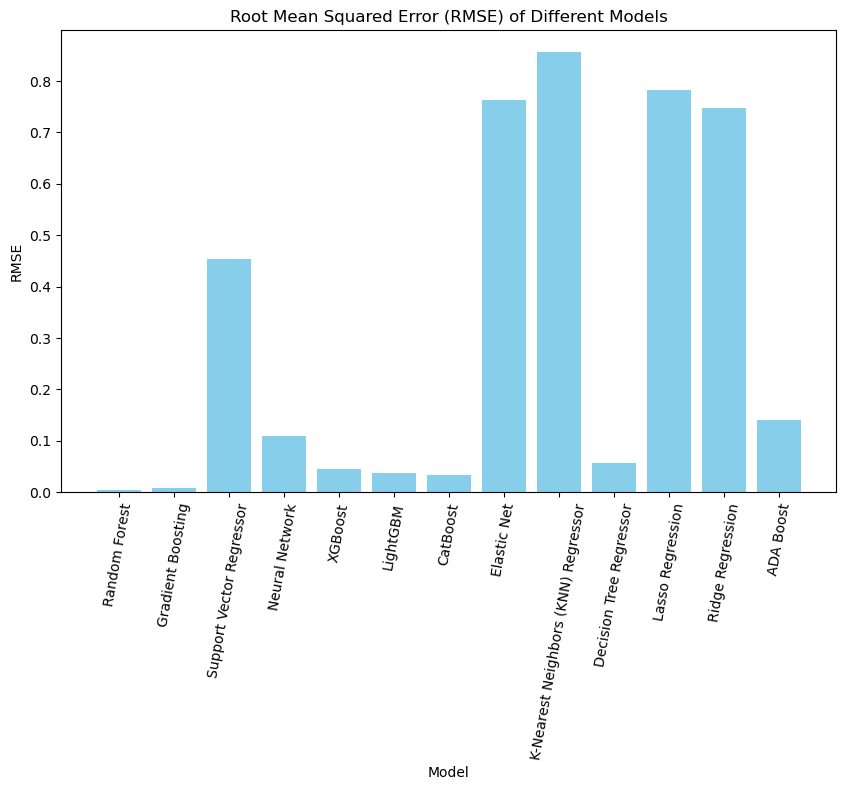

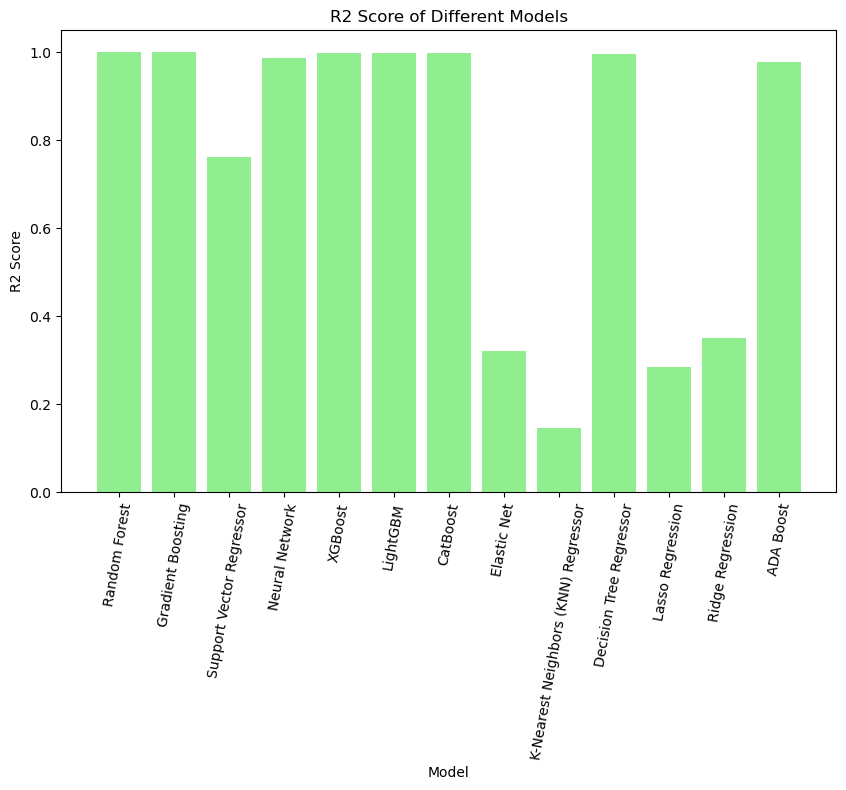

In [416]:
# Step 3: Visualize the Model Performance
import matplotlib.pyplot as plt

# Plot RMSE for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['RMSE'], color='skyblue')
plt.title('Root Mean Squared Error (RMSE) of Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=80)
plt.show()

# Plot R-squared for each model
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['R2 Score'], color='lightgreen')
plt.title('R2 Score of Different Models')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.xticks(rotation=80)
plt.show()

#### The most promising model is LightGBM

LightGBM Model Build

In [418]:
## Step 4: LightGBM Model ReBuild

# Initialize LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=42)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgb = lgb_model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9791
[LightGBM] [Info] Number of data points in the train set: 31715, number of used features: 66
[LightGBM] [Info] Start training from score 7.477650


## Feature Importance

In [362]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39644 entries, 0 to 39643
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   n_tokens_title                   39644 non-null  float64
 1   n_tokens_content                 39644 non-null  float64
 2   n_unique_tokens                  39644 non-null  float64
 3   n_non_stop_words                 39644 non-null  float64
 4   n_non_stop_unique_tokens         39644 non-null  float64
 5   num_hrefs                        39644 non-null  float64
 6   num_self_hrefs                   39644 non-null  float64
 7   num_imgs                         39644 non-null  float64
 8   num_videos                       39644 non-null  float64
 9   average_token_length             39644 non-null  float64
 10  num_keywords                     39644 non-null  float64
 11  data_channel_is_lifestyle        39644 non-null  float64
 12  data_channel_is_enterta

In [430]:
X_train_pd = pd.DataFrame(X_train, columns = X.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [422]:
X_train_pd.head

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,abs_title_sentiment_polarity,shares,title_content_interaction,readability_score,day_of_week,n_tokens_title,n_tokens_content,n_tokens_title^2,n_tokens_title n_tokens_content,n_tokens_content^2
0,1.528398,0.417959,-0.354088,0.824644,-0.531544,0.655344,-0.908324,-0.426526,-0.698352,1.582738,...,1.071912,1.092701,0.868579,0.376353,0.0,1.528398,0.417959,1.509353,0.620415,-0.750023
1,0.354764,-0.273790,-0.238961,0.310748,-0.382108,-1.112956,-1.424812,-0.426526,-0.698352,1.246885,...,-0.767843,-0.248338,-0.190318,-0.274875,0.0,0.354764,-0.273790,-0.987568,-0.104682,-0.840654
2,-1.405688,-0.475945,0.804509,-0.052552,1.142092,-0.670881,-0.391835,-0.426526,-0.698352,1.176728,...,-0.767843,-0.180220,-0.692753,-0.517815,0.0,-1.405688,-0.475945,1.102594,0.650191,-0.702917
3,0.354764,-0.880255,0.465600,-1.157146,1.034568,-0.228806,-0.391835,-0.185832,-0.698352,-0.624812,...,0.336010,-0.025405,-0.800520,-0.859559,0.0,0.354764,-0.880255,-0.987568,-0.316665,-0.204611
4,1.528398,-1.177171,1.588315,-2.004290,1.563057,-0.965598,-1.424812,-0.426526,-0.698352,-0.800404,...,-0.767843,0.301426,-1.028191,-1.143281,0.0,1.528398,-1.177171,1.509353,-1.781662,0.350544


In [424]:
# Get feature importance
importance = lgb_model.feature_importances_
feature_names = X_train_pd.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df)


                      Feature  Importance
58                     shares        1572
39                     LDA_02          99
22                 kw_avg_max          86
38                     LDA_01          47
27  self_reference_max_shares          47
..                        ...         ...
62             n_tokens_title           0
63           n_tokens_content           0
31       weekday_is_wednesday           0
34        weekday_is_saturday           0
36                 is_weekend           0

[67 rows x 2 columns]


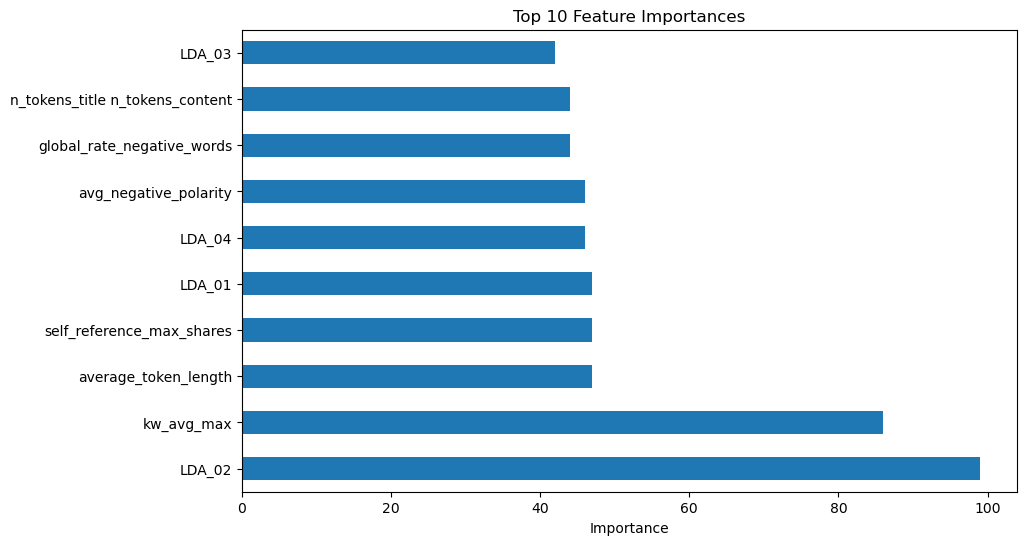

In [436]:
# Plot feature importance
feature_importances = pd.Series(lgb_model.feature_importances_, index=X.columns)
feature_importances = feature_importances.drop('shares')
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.show()

## Conclusion

- The RLight GBM model performed reasonably well, indicating that certain features strongly predict the number of shares.
- Key features contributing to the prediction were identified, and further model tuning or testing other algorithms could improve accuracy.

### Next Steps:
- Perform hyperparameter tuning to optimize model performance.
